finish direction analysis
- take into account causality score
- Look at length of the STR

In [8]:
# Set up
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats
import seaborn.apionly as sns

# Get all analyzed STRs
all_strs = pd.read_csv("all_analyzed_strs.bed", sep="\t", names=["chrom","str.start","end"])
all_strs["locus"] = all_strs.apply(lambda x: x["chrom"]+":"+str(x["str.start"]), 1)

# Get causal/best per gene for each tissue
DATADIR = "/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/"
GENEANNOT = "/storage/resources/dbase/human/hg19/gencode_gene_annotations_hg19.csv"
OUTPATH = "pdfs/"
TISSUES = [
    'Brain-Caudate(basalganglia)',
    'Brain-Cerebellum',
         'Muscle-Skeletal',
    'Cells-Transformedfibroblasts',
     'Esophagus-Mucosa',
     'Skin-NotSunExposed(Suprapubic)',
     'Skin-SunExposed(Lowerleg)',
     'Esophagus-Muscularis',
    'Artery-Aorta',
    'Artery-Tibial',
    'Adipose-Subcutaneous',
    'Adipose-Visceral(Omentum)',
     'Lung',
     'Thyroid',
     'Nerve-Tibial',
     'Heart-LeftVentricle',
     'WholeBlood',
]

# Get motifs
hipmotifs = pd.read_csv("/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif.bed", sep="\t", names=["chrom","str.start","str.end","period","motif"])
all_strs = pd.merge(all_strs, hipmotifs, on=["chrom","str.start"])
hipmotifs_s = pd.read_csv("/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif_stranded.bed", sep="\t",
                         names=["chrom","start","end","period","motif_pos","motif_neg"])
hipmotifs_s["str.start"] = hipmotifs_s["start"]
geneannot = pd.read_csv(GENEANNOT)
geneannot["gene"] = geneannot[["gene.id"]]
geneannot["tss"] = geneannot.apply(lambda x: [x["gene.stop"],x["gene.start"]][x["gene.strand"]=="+"], 1)

Populating the interactive namespace from numpy and matplotlib


In [9]:
# Get per-tissue data
data = {}
for t in TISSUES:
    d = pd.read_csv(os.path.join(DATADIR, t, "Master.table"), sep="\t")
    #d = pd.merge(d, geneannot[["gene","gene.strand"]], on=["gene"])
    #d = pd.merge(d, hipmotifs_s[["chrom","str.start","motif_pos","motif_neg"]], on=["chrom","str.start"])
    #d["motif_stranded"] = d.apply(lambda x: x["motif_pos"] if x["gene.strand"]=="+" else x["motif_neg"], 1)
    data[t] = d 

In [10]:
geneToStrand = {}
for i in range(geneannot.shape[0]):
    geneToStrand[geneannot["gene.id"].values[i]] = geneannot["gene.strand"].values[i]

In [11]:
def GetStrand(x, random=True):
    strands = [geneToStrand[item] for item in x]
    if random: strands = [strands[0]]
    return ",".join(set(strands))

def ConcatBeta(x):
    return ",".join([str(item) for item in x])

def GetStrandedMotif(x,label):
    if x["%s.strand"%label] == "+": return x["motif_pos"]
    elif x["%s.strand"%label] == "-": return x["motif_neg"]
    else: return None

In [12]:
# Load summary data
MAXQ = 0.1
MINSCORE = 0.1

SUMMARY = '/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/LR_SummaryTest_Table.tsv'
allpairs = pd.read_csv(SUMMARY, sep='\t')
allpairs["locus"] = allpairs.apply(lambda x: x["chrom"]+":"+str(x["str.start"]), 1)
allstrs = allpairs.groupby(["chrom","str.start"], as_index=False).agg({"E.tissues": sum})
allstrs['locus']=allstrs.apply(lambda x: x["chrom"]+":"+str(x["str.start"]), 1)
allstrs = pd.merge(allstrs, hipmotifs_s[["chrom","str.start","motif_pos","motif_neg"]], on=["chrom","str.start"])

# Recompute E.tissues field
estr_loci = []
estr_genes = []
estr_betas = []
for t in TISSUES:
    x = data[t]
    e = x[(x["qvalue"]<=MAXQ) & (x["best.str"]==1) ]
    e_loci = list(e.apply(lambda x: x["chrom"]+":"+str(x["str.start"]), 1))
    e_genes = list(e["gene"])
    e_betas = list(e["beta"])
    estr_loci.extend(e_loci)
    estr_genes.extend(e_genes)
    estr_betas.extend(e_betas)
allstrs["E.tissues"] = allstrs.apply(lambda x: estr_loci.count(x["locus"]), 1)

# Add Causal.tissues field 
causal_loci = []
causal_genes = []
causal_betas = []
causal_scores = []
for t in TISSUES:
    x = data[t]
    x["str.top"] = x["top.variant"].apply(lambda x: "SNP" not in str(x))
    c = x[(x["qvalue"]<=MAXQ) & (x["best.str"]==1) & (x["str.top"] | (x["top.str.score"]>=MINSCORE))]
    c_loci = list(c.apply(lambda x: x["chrom"]+":"+str(x["str.start"]), 1))
    c_genes = list(c["gene"])
    c_betas = list(c["beta"])
    c_scores = list(c["top.str.score"])
    causal_loci.extend(c_loci)
    causal_genes.extend(c_genes)
    causal_betas.extend(c_betas)
    causal_scores.extend(c_scores)
allstrs["C.tissues"] = allstrs.apply(lambda x: causal_loci.count(x["locus"]), 1)

In [13]:
# Map each STR eGenes and cGenes
allstrs = pd.read_csv("allstrs_tmp.csv")# avoid recomputing above

allestrs = pd.DataFrame({"locus": estr_loci, "gene": estr_genes, "beta": estr_betas})
allestrs["chrom"] = allestrs["locus"].apply(lambda x: x.split(":")[0], 1)
allestrs["str.start"] = allestrs["locus"].apply(lambda x: int(x.split(":")[1]), 1)
estrand = allestrs.groupby(["chrom","str.start"], as_index=False).agg({"gene": GetStrand, "beta": ConcatBeta})
estrand["e.strand"] = estrand["gene"]
estrand["e.beta"] = estrand["beta"]
allstrs = pd.merge(allstrs, estrand[["chrom","str.start","e.strand","e.beta"]], on=["chrom","str.start"], how="left")

allcestrs = pd.DataFrame({"locus": causal_loci, "gene": causal_genes, "beta": causal_betas, "scores": causal_scores})
allcestrs["chrom"] = allcestrs["locus"].apply(lambda x: x.split(":")[0], 1)
allcestrs["str.start"] = allcestrs["locus"].apply(lambda x: int(x.split(":")[1]), 1)
cstrand = allcestrs.groupby(["chrom","str.start"], as_index=False).agg({"gene": GetStrand, "beta": ConcatBeta})
cstrand["c.strand"] = cstrand["gene"]
cstrand["c.beta"] = cstrand["beta"]
allstrs = pd.merge(allstrs, cstrand[["chrom","str.start","c.strand","c.beta"]], on=["chrom","str.start"], how="left")

allnestrs = allpairs[allpairs["E.tissues"]==0]
nstrand = allnestrs.groupby(["chrom","str.start"], as_index=False).agg({"gene": lambda x: GetStrand(x, random=True)})
nstrand["n.strand"] = nstrand["gene"]
allstrs = pd.merge(allstrs, nstrand[["chrom","str.start","n.strand"]], on=["chrom","str.start"], how="left")

allstrs = pd.merge(allstrs, hipmotifs, on=["chrom","str.start"])

allstrs["stranded_motif_e"] = allstrs.apply(lambda x: GetStrandedMotif(x,"e"), 1)
allstrs["stranded_motif_c"] = allstrs.apply(lambda x: GetStrandedMotif(x,"c"), 1)
allstrs["stranded_motif_n"] = allstrs.apply(lambda x: GetStrandedMotif(x,"n"), 1)

In [14]:
allestrs.to_csv("allestrs_tmp.csv") # save tmp file
allcestrs.to_csv("allcestrs_tmp.csv") # save tmp file
allstrs.to_csv("allstrs_tmp.csv") # save tmp file

In [6]:
# Read from files to avoid recomputing
allstrs = pd.read_csv("allstrs_tmp.csv")# avoid recomputing above
allestrs = pd.read_csv("allestrs_tmp.csv")
allcestrs = pd.read_csv("allcestrs_tmp.csv")

In [15]:
# Get: 
# motif enrichment estr and causal
# strand info

OR_e = []
P_e = []
OR_c = []
P_c = []
strand_f_e = []
strand_r_e = []
strand_f_c = []
strand_r_c = []
strand_f_all = []
strand_r_all = []
total_count = []
total_e = []
total_c = []

def NormTable(t, total):
    t[1][1] = total-sum(t)
    return t

motifs = allstrs.groupby("motif", as_index=False).agg({"str.start":len})
motifs = list(motifs[motifs["str.start"]>=10].sort_values("str.start")["motif"])

num_total = allstrs.shape[0]
num_e_total = allstrs[allstrs["E.tissues"]>0].shape[0]
num_c_total = allstrs[allstrs["C.tissues"]>0].shape[0]

for m in motifs:
    x = allstrs[allstrs["motif"]==m]
    num_m = x.shape[0]
    num_e = x[x["E.tissues"]>=1].shape[0]
    num_c = x[x["C.tissues"]>=1].shape[0]
    t = [[num_e, num_e_total-num_e], [num_m-num_e, 0]]
    t = NormTable(t, num_total)
    odds_e, p_e = scipy.stats.fisher_exact(t)
    OR_e.append(odds_e)
    P_e.append(p_e)

    t = [[num_c, num_c_total-num_c], [num_m-num_c, 0]]
    t = NormTable(t, num_total)
    odds_c, p_c = scipy.stats.fisher_exact(t)
    OR_c.append(odds_c)
    P_c.append(p_c)
    
    e_stranded = x[(x["E.tissues"]>=1) & (x["stranded_motif_e"].apply(str) != "None")]
    se = e_stranded[e_stranded["stranded_motif_e"]==e_stranded["motif"]].shape[0]
    strand_f_e.append(se)
    strand_r_e.append(e_stranded.shape[0]-se)
    
    c_stranded = x[(x["C.tissues"]>=1) & (x["stranded_motif_c"].apply(str) != "None")]
    sc = c_stranded[c_stranded["stranded_motif_c"]==c_stranded["motif"]].shape[0]
    strand_f_c.append(sc)
    strand_r_c.append(c_stranded.shape[0]-sc)
    
    n_stranded = x[(x["E.tissues"]==0) & (x["stranded_motif_n"].apply(str) != "None")]
    sn = n_stranded[n_stranded["stranded_motif_n"]==n_stranded["motif"]].shape[0]
    strand_f_all.append(sn)
    strand_r_all.append(n_stranded.shape[0]-sn)
    
    total_count.append(num_m)
    total_e.append(num_e)
    total_c.append(num_c)
    #print("%s %s %s %s %s %s %s %s %s"%(m, odds_e, p_e, odds_c, p_c, se, e_stranded.shape[0]-se, sc, c_stranded.shape[0]-sc))

mdata_all = pd.DataFrame({
    "odds.e": OR_e,
    "p.e": P_e,
    "odds.c": OR_c,
    "p.c": P_c,
    "strand.f.e": strand_f_e,
    "strand.r.e": strand_r_e,
    "strand.f.c": strand_f_c,
    "strand.r.c": strand_r_c,
    "strand.f.all": strand_f_all,
    "strand.r.all": strand_r_all,
    "motif": motifs,
    "total": total_count,
    "total.e": total_e,
    "total.c": total_c
})
mdata_all = mdata_all.sort_values("odds.c", ascending=False)

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.4/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


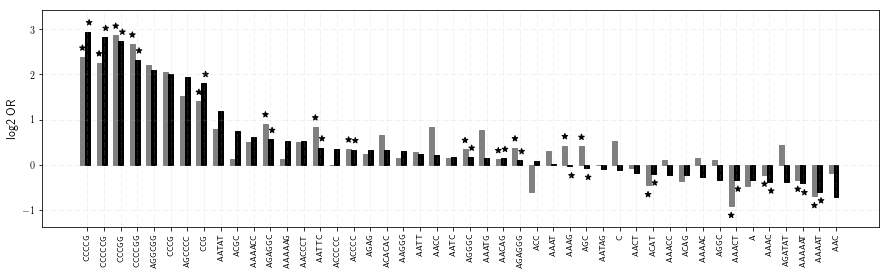

In [16]:
# Plot enrichments causal vs. not
pthresh = 0.05
mdata_plot = mdata_all[mdata_all["total.c"]>=3]
fig = plt.figure()
fig = plt.figure(figsize=(15,4))

# Plot enrichment
ax = fig.add_subplot(111)
w = 0.3
ax.bar(range(mdata_plot.shape[0]), np.log2(mdata_plot["odds.e"]), color="gray", edgecolor="gray", width=w)
ax.bar([item+w for item in range(mdata_plot.shape[0])], np.log2(mdata_plot["odds.c"]), color="black", edgecolor="black", width=w)

mdata_plot["color"] = mdata_plot.apply(lambda x: "black" if x["p.e"]<=pthresh/mdata_plot.shape[0] else "white" ,1)
mdata_plot["color_causal"] = mdata_plot.apply(lambda x: "black" if x["p.c"]<=pthresh/mdata_plot.shape[0] else "white" ,1)

def AddBuf(item, buf=0.1):
    if item >= 0: return item+buf
    else: return item-buf
ax.scatter([AddBuf(item, buf=0) for item in range(mdata_plot.shape[0])], list([AddBuf(np.log2(item), buf=0.2) for item in mdata_plot['odds.e']]), \
           color=list(mdata_plot['color']), marker='*')
ax.scatter([AddBuf(item, buf=0.4) for item in range(mdata_plot.shape[0])], list([AddBuf(np.log2(item), buf=0.2) for item in mdata_plot['odds.c']]), \
           color=list(mdata_plot['color']), marker='*')

ax.set_xticks([item+w for item in range(mdata_plot.shape[0])])
ax.set_xticklabels(list(mdata_all["motif"]), size=8, rotation='vertical')
ax.set_ylabel("log2 OR", size=12)
ax.grid(linestyle='--', alpha=0.2);
fig.savefig(os.path.join(OUTPATH, "OverallMotifEnrichment.pdf"))

In [17]:
def GetPerc(x, label):
    num = x["strand.f.%s"%label]
    denom = x["strand.f.%s"%label] + x["strand.r.%s"%label]
    if denom == 0: return None
    else: return num*1.0/denom
    
def GetBinom(x, label):
    num = x["strand.f.%s"%label]
    denom = x["strand.f.%s"%label] + x["strand.r.%s"%label]
    num_f = x["strand.f.all"]
    num_all = x["strand.f.all"]+x["strand.r.all"]
    p = num_f*1.0/num_all
    return scipy.stats.binom_test(num, denom, p=p)

mdata_all["perc.e"] = mdata_all.apply(lambda x: GetPerc(x, "e"), 1)
mdata_all["perc.c"] = mdata_all.apply(lambda x: GetPerc(x, "c"), 1)
mdata_all["perc.all"] = mdata_all.apply(lambda x: GetPerc(x, "all"), 1)
mdata_all["prob.e"] = mdata_all.apply(lambda x: GetBinom(x, "e"), 1)
mdata_all["prob.c"] = mdata_all.apply(lambda x: GetBinom(x, "c"), 1)
mdata_all.sort_values("prob.e")
#mdata_all[mdata_all["motif"]=="AAG"]

,motif,odds.c,odds.e,p.c,p.e,strand.f.all,strand.f.c,strand.f.e,strand.r.all,strand.r.c,strand.r.e,total,total.c,total.e,perc.e,perc.c,perc.all,prob.e,prob.c
8,CCCGG,6.680611,7.321546,0.017104,1.025864e-03,0,2,4,5,1,3,12,3,7,0.571429,0.666667,0.000000,0.000000,0.000000
33,CCCCCG,7.076669,4.794501,0.000577,3.708202e-04,10,1,3,2,5,8,23,6,11,0.272727,0.166667,0.833333,0.000061,0.000664
18,AGGCGG,4.294499,4.648655,0.044323,2.719369e-03,3,3,8,6,0,0,17,3,8,1.000000,1.000000,0.333333,0.000152,0.037037
77,AAAAAT,1.007282,1.239089,0.903564,1.055639e-01,152,6,22,152,12,50,376,18,72,0.305556,0.333333,0.500000,0.001294,0.237885
60,ACTC,0.000000,0.853511,0.115200,8.566468e-01,27,0,0,22,0,8,57,0,8,0.000000,NaN,0.551020,0.001651,1.000000
16,AAATG,1.335608,1.742851,0.541330,3.088578e-01,3,1,4,9,0,0,16,1,4,1.000000,1.000000,0.250000,0.003906,0.250000
65,AGATAT,1.054420,0.662568,0.792463,2.872782e-01,33,0,0,38,4,9,80,4,9,0.000000,0.000000,0.464789,0.004616,0.128723
5,AATTC,2.226125,1.307058,0.385612,6.676872e-01,1,1,2,7,0,0,10,1,2,1.000000,1.000000,0.125000,0.015625,0.125000
78,AGG,0.925238,1.438668,0.904248,4.300580e-03,147,9,50,155,8,33,385,17,83,0.602410,0.529412,0.486755,0.037073,0.810682
25,ATATC,0.000000,0.980268,1.000000,1.000000e+00,10,0,0,6,0,3,19,0,3,0.000000,NaN,0.625000,0.052734,1.000000


In [18]:
# Test strand for different motif classes
motif_classes = {
    "CG": ["C","CG","CCG","CCCG","CCCCG","CCCCCG","CCCGG"],
    "AG": ["AG","AGG","AGGG","AGGGG","AGGGGG"],
    "AC": ["AC","ACC","ACCC","ACCCC","ACCCCC"],
    "AT2": ["AT","AAT","AAAT","AAAAT","AAAAAT"],
    "AC2": ["AC","AAC","AAAC","AAAAC","AAAAAC"],
    "AG2": ["AG","AAG","AAAG","AAAAG","AAAAAG"],
    "mixACG": ["AGAGGG","AAGGG","AAGG","AGCCC"]
}
for mc in motif_classes:
    d = mdata_all[mdata_all["motif"].apply(lambda x: x in motif_classes[mc])]
    d["x"] = 1
    d = d.groupby("x", as_index=False).agg({"strand.f.e": sum, "strand.f.c": sum, \
                                            "strand.r.c": sum, "strand.r.e": sum, \
                                           "strand.f.all": sum, "strand.r.all": sum})
    perc_e = (d["strand.f.e"]*1.0/(d["strand.f.e"]+d["strand.r.e"])).values[0]
    perc_c = (d["strand.f.c"]*1.0/(d["strand.f.c"]+d["strand.r.c"])).values[0]
    perc_all = (d["strand.f.all"]*1.0/(d["strand.f.all"]+d["strand.r.all"])).values[0]
    p_e = scipy.stats.binom_test(d["strand.f.e"].values[0], (d["strand.f.e"]+d["strand.r.e"]).values[0], p=perc_all)
    p_c = scipy.stats.binom_test(d["strand.f.c"].values[0], (d["strand.f.c"]+d["strand.r.c"]).values[0], p=perc_all)
    print("%s %s %s %s %s %s"%(mc, perc_e, perc_c, perc_all, p_e, p_c))

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


mixACG 0.47468354430379744 0.391304347826087 0.4786418400876232 0.9366912547628029 0.24241253049628347
AT2 0.619625137816979 0.6397849462365591 0.6561202913305663 6.981002197986008e-05 0.35440779471230427
AG2 0.4777777777777778 0.4965034965034965 0.49234057712860707 0.373480288490316 0.9059352413862245
AC 0.46393146979260597 0.4767123287671233 0.46175376318394373 0.7748071124439552 0.25904218971663123
CG 0.5316901408450704 0.5046728971962616 0.5316326530612245 1.0 0.6283971148307159
AG 0.48174157303370785 0.43783783783783786 0.4903758020164986 0.6530021976081075 0.16255002895768084
AC2 0.4591775923718713 0.4613861386138614 0.4618124155141936 0.6683292829999754 0.982198047362745


In [19]:
###### Direction of effect, uniquify on chrom,start,gene

allcestrs["strand"] = allcestrs["gene"].apply(lambda x: geneToStrand[x])
allcestrs2 = pd.merge(allcestrs[["chrom","str.start","gene","strand","beta","scores"]], allstrs[["chrom","str.start","motif_pos","motif_neg"]])
allcestrs2["motif_stranded"] = allcestrs2.apply(lambda x: [x["motif_neg"],x["motif_pos"]][x["strand"]=="+"], 1)
allcestrs3 = allcestrs2.groupby(["chrom","str.start","gene"], as_index=False).agg({"motif_stranded": lambda x: x.values[0], "strand": lambda x: x.values[0], "scores": max, "beta": np.median})
allcestrs3 = pd.merge(allcestrs3, geneannot[["tss","gene"]], on=["gene"])
allcestrs3["dist.tss"] = allcestrs3.apply(lambda x: (x["str.start"]-x["tss"]) if x["strand"]=="+" else -1*(x["str.start"]-x["tss"]) , 1)

allestrs["strand"] = allestrs["gene"].apply(lambda x: geneToStrand[x])
allestrs2 = pd.merge(allestrs[["chrom","str.start","gene","strand","beta"]], allstrs[["chrom","str.start","motif_pos","motif_neg"]])
allestrs2["motif_stranded"] = allestrs2.apply(lambda x: [x["motif_neg"],x["motif_pos"]][x["strand"]=="+"], 1)
allestrs3 = allestrs2.groupby(["chrom","str.start","gene"], as_index=False).agg({"motif_stranded": lambda x: x.values[0], "strand": lambda x: x.values[0], "beta": np.median})
allestrs3 = pd.merge(allestrs3, geneannot[["tss","gene"]], on=["gene"])
allestrs3["dist.tss"] = allestrs3.apply(lambda x: (x["str.start"]-x["tss"]) if x["strand"]=="+" else -1*(x["str.start"]-x["tss"]) , 1)

allcestrs3 = pd.merge(allcestrs3, hipmotifs[["chrom","str.start","str.end"]], on=["chrom","str.start"])
allcestrs3["reflen"] = allcestrs3["str.end"]-allcestrs3["str.start"]+1
allestrs3 = pd.merge(allestrs3, hipmotifs[["chrom","str.start","str.end"]], on=["chrom","str.start"])
allestrs3["reflen"] = allestrs3["str.end"]-allestrs3["str.start"]+1

allcestrs3["absdist"] = allcestrs3["dist.tss"].apply(abs)
allestrs3["absdist"] = allestrs3["dist.tss"].apply(abs)

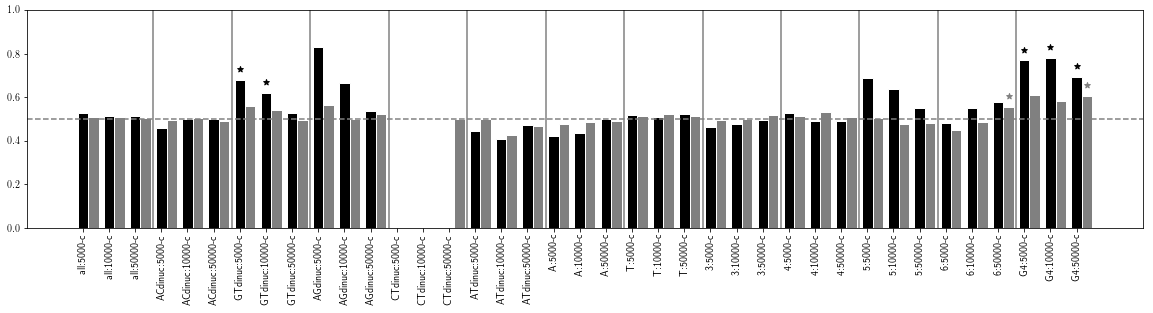

In [24]:
percs = []
pvals = []
mcs = []
mindists = []
labels = []
colors = []
edgecolors = []
minnum = 5 # Min num examples to include

# Sawaya et al overlap frac > 0.8 Table 4
# Note all the negative G4 ones are *before* the TSS
motif_classes = {
    "CG": ["C","CG","CCG","CCCG","CCCCG","CCCCCG","CCCGG"],
    "CG2": ["G","CG","CGG","CGGG","CGGGG","CGGGGG","CCGGG"],
    "AG": ["AG","AGG","AGGG","AGGGG","AGGGGG"],
    "CT": ["CT","CCT","CCCT","CCCCT","CCCCCT"],
    "AC": ["AC","ACC","ACCC","ACCCC","ACCCCC"],
    "GT": ["GT","GGT","GGGT","GGGGT","GGGGGT"],
    "CG_dinuc": ["CG"],
    "AG_dinuc": ["AG"],
    "CT_dinuc": ["CG"],
    "AC_dinuc": ["AC"],
    "GT_dinuc": ["GT"],
    "AT_dinuc": ["AT"],
    "AT": ["AT","AAT","AAAT","AAAAT","AAAAAT"],
    "AT2": ["TA","ATT","ATTT","ATTTT","ATTTTT"],
    "AC2": ["AC","AAC","AAAC","AAAAC","AAAAAC"],
    "GT2": ["GT","GTT","GTTT","GTTTT","GTTTTT"],
    "AG2": ["AG","AAG","AAAG","AAAAG","AAAAAG"],
    "CT2": ["CT","CTT","CTTT","CTTTT","CTTTTT"],
    "A": ["A"],
    "T": ["T"],
    "3": [item for item in set(allstrs["stranded_motif_c"].values) if item is not None and len(item)==3],
    "4": [item for item in set(allstrs["stranded_motif_c"].values) if item is not None and len(item)==4],
    "5": [item for item in set(allstrs["stranded_motif_c"].values) if item is not None and len(item)==5],
    "6": [item for item in set(allstrs["stranded_motif_c"].values) if item is not None and len(item)==6],
    "2": [item for item in set(allstrs["stranded_motif_c"].values) if item is not None and len(item)==2],
    "1": [item for item in set(allstrs["stranded_motif_c"].values) if item is not None and len(item)==1],
}
for m in ["AG","AC","AT","CT","GT","CG"]:
    motif_classes["%s_all"%m] = motif_classes[m]+motif_classes["%s2"%m]
motif_classes["AC_all"] = motif_classes["AC"]+motif_classes["AC2"]
motif_classes["G4"] = ["AGGG","CCCT","ACCC","GGGT","AGGGG","CCCCT","C","G","ACCCC","GGGGT", \
                      "CCCG","CGGG","CCCCG","CGGGG", \
                      "AGCCC","GGGCT","AGGGC","GCCCT", \
                      "ACCCCC","GGGGT", \
                      "CCCCCG","CGGGGG","CCCGG","CCGGG","CCCCGG"]
motif_classes["all"] = set(allcestrs3["motif_stranded"])
motif_classes["noG4"] = set(allcestrs3["motif_stranded"]).difference(set(motif_classes["G4"]))

for mc in ["all","AC_dinuc","GT_dinuc","AG_dinuc","CT_dinuc","AT_dinuc","A","T", "3","4","5","6", "G4"]:
    for mindist in [5000, 10000, 50000]:
        bs_c = allcestrs3[(allcestrs3["absdist"]<=mindist) & (allcestrs3["motif_stranded"].apply(lambda x: x in motif_classes[mc]))]["beta"]
        bs_c_dir = [item>0 for item in bs_c]
        if len(bs_c_dir) <= minnum: 
            percs.append(0)
            pvals.append(None)
        else:
            percs.append(np.mean(bs_c_dir))
            pvals.append(scipy.stats.binom_test(sum(bs_c_dir), len(bs_c_dir)))
        mcs.append(mc)
        labels.append("%s:%s-c"%(mc, mindist))
        colors.append("black")
        edgecolors.append("white")
        mindists.append(mindist)
        
        bs_e = allestrs3[(allestrs3["absdist"]<=mindist) & (allestrs3["motif_stranded"].apply(lambda x: x in motif_classes[mc]))]["beta"]
        bs_e_dir = [item>0 for item in bs_e]
        if len(bs_e_dir) <= minnum: 
            percs.append(0)
            pvals.append(None)
        else:
            percs.append(np.mean(bs_e_dir))
            pvals.append(scipy.stats.binom_test(sum(bs_e_dir), len(bs_e_dir)))
        mcs.append(mc)
        labels.append("%s:%s-e"%(mc, mindist))
        colors.append("gray")
        edgecolors.append("white")
        mindists.append(mindist)
        
dir_data = pd.DataFrame({"motifclass": mcs,
             "mindist": mindists,
              "perc": percs,
              "pval": pvals,
              "label": labels,
              "color": colors,
              "edge": edgecolors
             })

w = 0.4
fig = plt.figure()
fig.set_size_inches((20, 4))
ax = fig.add_subplot(111)
x = dir_data[dir_data["label"].apply(lambda x: "-c" in x)]
ax.bar(range(x.shape[0]), x["perc"], color=x["color"], edgecolor=x["edge"], width=w);
ax.axhline(y=0.5, linestyle="dashed", color="gray")
for i in range(x.shape[0]):
    if i%len(set(x["mindist"])) == 0 and i!=0: ax.axvline(x=i-0.3, color="gray")
ax.set_xticks(range(x.shape[0]))
ax.set_xticklabels([item.replace("_","") for item in x["label"]], rotation=90);
ax.set_ylim(bottom=0, top=1)
sig = [i for i in range(len(x["pval"])) if x["pval"].values[i]<0.05]
yvals = [x["perc"].values[i]+0.05 for i in sig]
ax.scatter(sig, yvals, marker="*", color="black")

#fig = plt.figure()
#fig.set_size_inches((15, 4))
#ax = fig.add_subplot(111)
x = dir_data[dir_data["label"].apply(lambda x: "-e" in x)]
ax.bar([item+w for item in range(x.shape[0])], x["perc"], color=x["color"], edgecolor=x["edge"], width=w);
sig = [i for i in range(len(x["pval"])) if x["pval"].values[i]<0.05]
yvals = [x["perc"].values[i]+0.05 for i in sig]
ax.scatter([item+w for item in sig], yvals, marker="*", color="gray")
fig.savefig("pdfs/DirectionOfEffect.pdf")
#ax.axhline(y=0.5, linestyle="dashed", color="gray")
#for i in range(x.shape[0]):
#    if i%len(set(x["mindist"])) == 0 and i!=0: ax.axvline(x=i-0.5, color="black")
#ax.set_xticks(range(x.shape[0]))
#ax.set_xticklabels([item.replace("_","") for item in x["label"]], rotation=90);
#ax.set_ylim(bottom=0, top=1);

In [28]:
allcestrs3[(allcestrs3["motif_stranded"].apply(lambda x: x in motif_classes["6"]))].sort_values("beta")

,chrom,str.start,gene,motif_stranded,strand,scores,beta,tss,dist.tss,str.end,reflen,absdist
1559,chr12,66687704,ENSG00000127311.5,CTTTTT,+,0.395446,-0.465651,66696325,-8621,66687754,51,8621
620,chr1,205663995,ENSG00000117280.8,GTTTTT,-,0.281629,-0.421713,205744588,80593,205664032,38,80593
5541,chr6,112480329,ENSG00000203778.3,AAAACT,+,0.095136,-0.395578,112408802,71527,112480350,22,71527
1857,chr14,23526871,ENSG00000139880.15,CCCCCG,-,0.116957,-0.381972,23526747,-124,23526893,23,124
3025,chr19,493972,ENSG00000099866.10,CTCTCT,+,0.193353,-0.372059,489176,4796,494019,48,4796
2238,chr15,82416402,ENSG00000183496.5,GTTTTT,-,0.106699,-0.371999,82338482,-77920,82416438,37,77920
1861,chr14,24036897,ENSG00000213983.7,CCGCTG,-,0.155714,-0.364193,24036897,0,24036920,24,0
2250,chr15,85193586,ENSG00000177082.8,AAAAAG,-,0.178314,-0.347209,85197574,3988,85193607,22,3988
2374,chr16,28904728,ENSG00000178188.10,AAAAAG,+,0.086506,-0.335178,28857921,46807,28904751,24,46807
5857,chr7,128308083,ENSG00000205085.4,AAAATT,+,0.145548,-0.326152,128312342,-4259,128308108,26,4259


# Scratch below

In [ ]:
# Make into single data frame
d_tissues = []
d_motifs = []
d_p = []
d_odds = []
d_p_c = []
d_odds_c = []
d_num = []
d_num_c = []
d_f = []
d_r = []
d_f_c = []
d_r_c = []
d_f_all = []
d_r_all = []

for i in range(num_tissues+1):
    for j in range(num_motifs):
        if i == num_tissues:
            d_tissues.append("ALL")
        else: d_tissues.append(TISSUES[i])
        d_motifs.append(motifs[j])
        d_p.append(P_e_all[j][i])
        d_odds.append(OR_e_all[j][i])
        d_p_c.append(P_ec_all[j][i])
        d_odds_c.append(OR_ec_all[j][i])
        d_num.append(total[j][i])
        d_num_c.append(total_c[j][i])
        d_f.append(strand_e_f[j][i])
        d_r.append(strand_e_r[j][i])
        d_f_c.append(strand_ec_f[j][i])
        d_r_c.append(strand_ec_r[j][i])
        d_f_all.append(strand_all_f[j][i])
        d_r_all.append(strand_all_r[j][i])

mdata = pd.DataFrame({
  "tissue": d_tissues,
    "motif": d_motifs,
    "enrich.p": d_p,
    "enrich.odds": d_odds,
    "enrich.p.causal": d_p_c,
    "enrich.odds.causal": d_odds_c,
    "num": d_num,
    "num.causal": d_num_c,
    "strand.f.estr": d_f,
    "strand.r.estr": d_r,
    "strand.f.causal": d_f_c,
    "strand.r.causal": d_r_c,
    "strand.f.all": d_f_all,
    "strand.r.all": d_r_all
})
cols = ["tissue","motif","num","num.causal","enrich.p","enrich.odds","enrich.p.causal","enrich.odds.causal", \
       "strand.f.estr","strand.r.estr","strand.f.causal","strand.r.causal","strand.f.all","strand.r.all"]

mdata = mdata[cols]
mdata_all = mdata[mdata["tissue"]=="ALL"].sort_values("enrich.odds")

In [ ]:
TCOLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
    "permuted": "gray"
}

In [ ]:
pthresh = 0.05

fig = plt.figure()
fig = plt.figure(figsize=(10,8))
plt.subplots_adjust( hspace=0)

# Plot tissue grid
ax = fig.add_subplot(211)
tnum = 0
for i in range(len(TISSUES)):
    t=(TISSUES[i])
    tnum += 1
    Y = [tnum]*mdata_all.shape[0]
    X = [item for item in range(mdata_all.shape[0])]
    X2 = [item+w for item in range(mdata_all.shape[0])]
    motifs = mdata_all["motif"]
    colors = [["white", TCOLORS[t.split("(")[0]]][mdata[(mdata["motif"]==m) & (mdata["tissue"]==t)]["enrich.p"].values[0]<=pthresh/mdata.shape[0]] for m in motifs]
    colors2 = [["white", TCOLORS[t.split("(")[0]]][mdata[(mdata["motif"]==m) & (mdata["tissue"]==t)]["enrich.p.causal"].values[0]<=pthresh/mdata.shape[0]] for m in motifs]
    #ax.scatter(X2, Y, color=colors2, marker='s')
    ax.scatter(X, Y, color=colors, marker='*')

ax.set_yticks([i for i in range(1,len(TISSUES)+1,1)])
ax.set_yticklabels(TISSUES, size=11, rotation=15);
plt.setp(ax.get_xticklabels(), visible=False)

# Plot enrichment
ax = fig.add_subplot(212, sharex=ax)
w = 0.3
ax.bar(range(mdata_all.shape[0]), np.log2(mdata_all["enrich.odds"]), color="black", edgecolor="white", width=w)
ax.bar([item+w for item in range(mdata_all.shape[0])], np.log2(mdata_all["enrich.odds.causal"]), color="white", edgecolor="black", width=w)

mdata_all["color"] = mdata_all.apply(lambda x: "black" if x["enrich.p"]<=pthresh/mdata.shape[0] else "white" ,1)
mdata_all["color_causal"] = mdata_all.apply(lambda x: "black" if x["enrich.p.causal"]<=pthresh/mdata.shape[0] else "white" ,1)

def AddBuf(item, buf=0.1):
    if item >= 0: return item+buf
    else: return item-buf
ax.scatter([AddBuf(item, buf=0) for item in range(mdata_all.shape[0])], list([AddBuf(np.log2(item), buf=0.2) for item in mdata_all['enrich.odds']]), \
           color=list(mdata_all['color']), marker='*', s=10)
ax.scatter([AddBuf(item, buf=0.35) for item in range(mdata_all.shape[0])], list([AddBuf(np.log2(item), buf=0.2) for item in mdata_all['enrich.odds.causal']]), \
           color=list(mdata_all['color']), marker='*', s=10)

ax.set_xticks([item+w for item in range(mdata_all.shape[0])])
ax.set_xticklabels(list(mdata_all["motif"]), size=8, rotation='vertical')
ax.set_ylabel("log2 OR", size=12)
ax.grid(linestyle='--', alpha=0.2)

In [21]:
mcpairs = [("AG_all","CT_all"), ("AC_all","GT_all"), ("AT_all",), ("CG_all",), \
           ("A","T"), \
           ("AC_dinuc","GT_dinuc"), ("AG_dinuc","CT_dinuc"), \
           ("AC","GT"), ("AG","CT"), ("CG", "CG2"), ("AT","AT2"), \
           ("AC2","GT2"), ("AG2","CT2"), \
           ("1","2","3","4","5","6"), \
           ]

"""
colors = ["red","blue"]
pcolors = ["gray","red","gold","blue","green","purple"]
mindist = 5000 # this much away from TSS
for mcp in mcpairs:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    i = 0
    for mc in mcp:
        print(mc)
        # causal
        bs_c = allcestrs3[(allcestrs3["absdist"]<=mindist) & (allcestrs3["motif_stranded"].apply(lambda x: x in motif_classes[mc]))]["beta"]
        counts, bins = np.histogram(bs_c, bins=50)
        total = sum(counts)
        counts = np.cumsum(counts)/total
        if len(mcp) == 6: 
            c = pcolors[i]
        else: c = colors[i]
        ax.plot(bins[:-1], counts, label=mc.replace("_",":"), color=c)
        print(scipy.stats.binom_test(sum([item>0 for item in bs_c]), bs_c.shape[0]))
        
        # estr
        bs_e = allestrs3[(allestrs3["absdist"]<=mindist) & (allestrs3["motif_stranded"].apply(lambda x: x in motif_classes[mc]))]["beta"]
        counts, bins = np.histogram(bs_e, bins=50)
        total = sum(counts)
        counts = np.cumsum(counts)/total
        ax.plot(bins[:-1], counts, label=mc.replace("_",":"), color=c, linestyle="dashed")
        print(scipy.stats.binom_test(sum([item>0 for item in bs_e]), bs_e.shape[0]))

        # grid
        ax.axvline(x=0, linestyle="dashed", color="gray")
        ax.axhline(y=0.5, linestyle="dashed", color="gray")
        i+= 1
    ax.legend(loc="upper left")   
"""

'\ncolors = ["red","blue"]\npcolors = ["gray","red","gold","blue","green","purple"]\nmindist = 5000 # this much away from TSS\nfor mcp in mcpairs:\n    fig = plt.figure()\n    ax = fig.add_subplot(111)\n    i = 0\n    for mc in mcp:\n        print(mc)\n        # causal\n        bs_c = allcestrs3[(allcestrs3["absdist"]<=mindist) & (allcestrs3["motif_stranded"].apply(lambda x: x in motif_classes[mc]))]["beta"]\n        counts, bins = np.histogram(bs_c, bins=50)\n        total = sum(counts)\n        counts = np.cumsum(counts)/total\n        if len(mcp) == 6: \n            c = pcolors[i]\n        else: c = colors[i]\n        ax.plot(bins[:-1], counts, label=mc.replace("_",":"), color=c)\n        print(scipy.stats.binom_test(sum([item>0 for item in bs_c]), bs_c.shape[0]))\n        \n        # estr\n        bs_e = allestrs3[(allestrs3["absdist"]<=mindist) & (allestrs3["motif_stranded"].apply(lambda x: x in motif_classes[mc]))]["beta"]\n        counts, bins = np.histogram(bs_e, bins=50)\n    

In [ ]:
# Plot strand info
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)

w = 0.2
xvals = range(mdata_all.shape[0])
xvals2 = [item+w for item in xvals]
xvals3 = [item+w*2 for item in xvals]

def GetPerc(x, label):
    total = (x["strand.f.%s"%label]+x["strand.r.%s"%label])
    if total == 0: return None
    return x["strand.f.%s"%label]/total

def GetInv(item):
    if item is None: return None
    else: return -1*(1-item)
    
perc_estr = mdata_all.apply(lambda x: GetPerc(x, "estr") , 1)
perc_cestr = mdata_all.apply(lambda x: GetPerc(x, "causal") , 1)
perc_all = mdata_all.apply(lambda x: GetPerc(x, "all") , 1)

ax.bar(xvals, perc_estr, color="red", width=w)
ax.bar(xvals, [-1*(1-item) for item in perc_estr], color="red", width=w)
ax.bar(xvals2, perc_cestr, color="blue", width=w)
ax.bar(xvals2, [GetInv(item) for item in perc_cestr], color="blue", edgecolor="blue", width=w)
ax.bar(xvals3, perc_all, color="black", width=w)
ax.bar(xvals3, [GetInv(item) for item in perc_all], color="black", width=w)
ax.set_ylim(bottom=-1.1, top=1.1)
ax.axhline(y=1, linestyle="dashed", color="gray")
ax.axhline(y=-1, linestyle="dashed", color="gray")
ax.axhline(y=0.5, linestyle="dashed", color="gray", lw=0.5)
ax.axhline(y=-0.5, linestyle="dashed", color="gray", lw=0.5)

ax.axhline(y=0, linestyle="dashed", color="gray")

ax.set_xticks([item+w for item in xvals]);
ax.set_xticklabels(mdata_all["motif"], rotation="vertical", size=8);
fig.savefig("pdfs/Figure3_motif_strands.pdf")

In [19]:
#### Direction of effect ###
motif_classes = {
    "CG": ["C","CG","CCG","CCCG","CCCCG","CCCCCG","CCCGG"],
    "CG2": ["G","CG","CGG","CGGG","CGGGG","CGGGGG","CCGGG"],
    "AG": ["AG","AGG","AGGG","AGGGG","AGGGGG"],
    "CT": ["CT","CCT","CCCT","CCCCT","CCCCCT"],
    "AC": ["AC","ACC","ACCC","ACCCC","ACCCCC"],
    "GT": ["GT","GGT","GGGT","GGGGT","GGGGGT"],
    "CG_dinuc": ["CG"],
    "AG_dinuc": ["AG"],
    "CT_dinuc": ["CG"],
    "AC_dinuc": ["AC"],
    "GT_dinuc": ["GT"],
    "AT_dinuc": ["AT"],
    "AT": ["AT","AAT","AAAT","AAAAT","AAAAAT"],
    "AT2": ["TA","ATT","ATTT","ATTTT","ATTTTT"],
    "AC2": ["AC","AAC","AAAC","AAAAC","AAAAAC"],
    "GT2": ["GT","GTT","GTTT","GTTTT","GTTTTT"],
    "AG2": ["AG","AAG","AAAG","AAAAG","AAAAAG"],
    "CT2": ["CT","CTT","CTTT","CTTTT","CTTTTT"],
    "A": ["A"],
    "T": ["T"],
    "3": [item for item in set(allstrs["stranded_motif_c"].values) if item is not None and len(item)==3],
    "4": [item for item in set(allstrs["stranded_motif_c"].values) if item is not None and len(item)==4],
    "5": [item for item in set(allstrs["stranded_motif_c"].values) if item is not None and len(item)==5],
    "6": [item for item in set(allstrs["stranded_motif_c"].values) if item is not None and len(item)==6],
    "2": [item for item in set(allstrs["stranded_motif_c"].values) if item is not None and len(item)==2],
    "1": [item for item in set(allstrs["stranded_motif_c"].values) if item is not None and len(item)==1],
}
for m in ["AG","AC","AT","CT","GT","CG"]:
    motif_classes["%s_all"%m] = motif_classes[m]+motif_classes["%s2"%m]
motif_classes["AC_all"] = motif_classes["AC"]+motif_classes["AC2"]

def GetBetaUp(x):
    betas = []
    #for item in x: betas.extend(item.split(","))
    for item in x:
        betas.append(np.mean([float(b) for b in item.split(",")]))
    return sum([float(item)>0 for item in betas])

def GetNum(x):
    betas = []
    #for item in x: betas.extend(item.split(","))
    for item in x:
        betas.append(np.mean([float(b) for b in item.split(",")]))
    return len(betas)

allstrs["e.beta2"] = allstrs["e.beta"]
allstrs["c.beta2"] = allstrs["c.beta"]

betas = allstrs[allstrs["C.tissues"]>=1].groupby("stranded_motif_c", as_index=False).agg({"c.beta2": GetNum, \
                                                                                          "c.beta": GetBetaUp})

ebetas = allstrs[allstrs["E.tissues"]>=1].groupby("stranded_motif_e", as_index=False).agg({ "e.beta2": GetNum, \
                                                                                         "e.beta": GetBetaUp})
d_motifs = []
d_dir_c = []
d_p_c = []
d_dir_e = []
d_p_e = []
for mc in motif_classes:
    d = betas[betas["stranded_motif_c"].apply(lambda x: x in motif_classes[mc])]
    d["x"] = 1
    x = d.groupby("x", as_index=False).agg({"c.beta2": sum, "c.beta": sum})
    total = x["c.beta2"].values[0]
    up = x["c.beta"].values[0]
    p = scipy.stats.binom_test(up, total)
    d_motifs.append(mc)
    d_dir_c.append(up*1.0/total)
    d_p_c.append(p)
    
    d = ebetas[ebetas["stranded_motif_e"].apply(lambda x: x in motif_classes[mc])]
    d["x"] = 1
    x = d.groupby("x", as_index=False).agg({"e.beta2": sum, "e.beta": sum})
    total = x["e.beta2"].values[0]
    up = x["e.beta"].values[0]
    p = scipy.stats.binom_test(up, total)
    d_dir_e.append(up*1.0/total)
    d_p_e.append(p)
    
    #print("%s %s %s %s"%(mc, total, up*1.0/total, p))
dir_data = pd.DataFrame({"motifclass": d_motifs, "dir.causal": d_dir_c, "p.causal": d_p_c, \
                        "dir.estr": d_dir_e, "p.estr": d_p_e}).sort_values("p.causal")

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.4/site-packages/ipykernel/__main__.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
set(mdata["tissue"])

In [ ]:
mdata_t = mdata[mdata["tissue"] == "Thyroid"]
label="estr"
def ComputeBinom(a,b,c):
    try:
        return scipy.stats.binom_test(a,b,p=c)
    except: return None
    
pval_estr = [ComputeBinom(mdata_t["strand.f.%s"%label].values[i], \
                       mdata_t["strand.f.%s"%label].values[i]+mdata_t["strand.r.%s"%label].values[i],
                      mdata_t["strand.f.all"].values[i]/(mdata_t["strand.f.all"].values[i]+mdata_t["strand.r.all"].values[i])) \
for i in range(mdata_t.shape[0])]

label="causal"
pval_cestr = [ComputeBinom(mdata_t["strand.f.%s"%label].values[i], \
                       mdata_t["strand.f.%s"%label].values[i]+mdata_t["strand.r.%s"%label].values[i],
                      mdata_t["strand.f.all"].values[i]/(mdata_t["strand.f.all"].values[i]+mdata_t["strand.r.all"].values[i])) \
for i in range(mdata_t.shape[0])]

mdata_t["p.strand.estr"] = pval_estr
mdata_t["p.strand.causal"] = pval_cestr
mdata_t.sort_values("p.strand.estr")[["motif","strand.f.estr","strand.r.estr","strand.f.causal","strand.r.causal","p.strand.estr","p.strand.causal"]]